## RNN-딥러닝을 이용한 문서 분류

딥러닝은 카운트벡터와 달리 **단어의 순서**를 반영해 문맥을 이해하는 방식으로 작동한다.
RNN은 문장을 이해하기 위해 단어의 순서를 고려하는 가장 직관적인 모델이다.

### Q1. 왜 RNN인가?
순환신경망이라고 부르는 RNN(Recurrent Neural Networks)은 시계열 데이터를 다루기 위한 모형으로 알려져 있다.
일정한 시간 간격으로 측정한 시계열 데이터에는 **특정한 규칙성이나 패턴이 있는 경우**에, 이러한 패턴을 기반으로 다음 값을 예측하는 것이 가능하다.
시계열 예측모형에서 가장 중요한 것은 **앞의 값들이 뒤의 값에 영향을 미친다는 것**이다.

#### Q2. RNN이 문서 분류에 적합한 이유
RNN이 앞에서부터 순차적으로 미치는 영향을 계속 축적하는 모형이다.
문맥은 단어들의 순서를 통해서 형성되는데, RNN은 구조상 이와 같은 문맥을 파악하기에 좋은 모형이다.
앞 단어로부터 문맥에 관한 정보가 마지막 노드까지 순차적으로 축적되면 그 정보를 이용해 문서를 분류하면 된다.
I/ am/ so/ happy → 긍정, 부정 파악
**최근에 RNN보다 더 좋은 모형이 나왔고, RNN은 경사소실 문제가 심각하기 때문에 좋은 모형은 아니다.**

### word-embedding
딥러닝 모형에 단어를 입력으로 사용하기 위해서는 one-hot-vector로 표현해야 하고 이를 다시 짧은 길이의 밀집벡터로 변환해야 한다.
딥러닝에서는 기본적으로 문서를 단어의 sequence로 표현하고, 각 단어들은 고정된 길이의 벡터가 되어야 한다.

dummy-변수 : 0과 1만으로 범주형 데이터를 표현한다.
one-hot-encoding : 범주형 데이터를 벡터 형태의 연속된 수치로 변환한 것 (이 결과는 one-hot-vector임)

embedding : 희소벡터 생성을 막기 위해, 범주형 데이터를 연속적인 값을 갖는, 상대적으로 **작은 크기의 벡터로 변환**하는 작업을 의미한다. (축소)

#### Q. embedding을 하는 이유
1 . 차원이 큰 원핫 벡터를 그대로 쓰면 연산이 비효율적이다.
2 . 대상간의 의미적 유사도를 계산할 수 있다. (모든 데이터 간의 거리가 동일하게 유지된다.)
3 . 단어가 의미적인 정보를 함축함으로써 연산이 가능해질 수 있다. → 연관있는 단어들의 관계를 이용해 연산을 수행하여 추론을 한다.
4 . 전이학습이 가능하다. (학습된 가중치 행렬을 이용해 밀집 벡터를 계산한다. → 시간 절약)

#### 1. RNN을 이용한 문서분류 - NLTK 영화 리뷰 감성분석

감성분석은 긍정과 부정 중 하나를 선택하는 이진 분류 문제

최종 출력단 크기 : 1
활성화 함수 : sigmoid
손실함수 : binary crossentropy

In [14]:
##데이터 준비
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids()

reviews = [movie_reviews.raw(fileid) for fileid in fileids]

categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print("#Reviews count:", len(reviews))
print("Length of the first review:", len(reviews[0]))
print("Labels:", set(categories))

#Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 #사용할 단어의 수

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
# oov_token : 사전에 없는 단어들(max_words에 포함X)를 공통 단어로 표기할 것인가?
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')

tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

#만들어진 단어 인덱스를 이용해 문서들을 변환
X = tokenizer.texts_to_sequences(reviews)

#몇개의 인덱스가 변환되었는지 알려주는듯
print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [16]:
#각 단어들이 몇번째 인덱스에 해당되는가?
import numpy as np
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [17]:
#시퀀스의 크기가 maxlen보다 크면 남는 부분을 자른다. - truncating 매개변수 사용
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500 #문서 안의 단어의 수 500개로 제한

# 'pre' : 앞을 자르고 뒷부분을 사용 (post는 반대)
X = pad_sequences(X, maxlen = max_len, truncating = 'pre')

In [18]:
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


In [19]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


### 일반적인 신경망 모형

구성 : embedding layer, flatten layer, dense layer

embedding layer : RNN을 위해 만든 입력을 받아 one-hot-encoding과 word-embedding을 수행하는 layer
flatten layer : 2차원 행렬의 형태로 된 값을 펼쳐서 1차원 벡터로 변환한다.
dense layer : 모든 노드들이 연결되는 밀집 층

In [20]:
# 케라스 모형 생성 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([ #순차적 모형
    Embedding(max_words, 32, input_length=max_len), #word embedding layer 생성
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(), # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])

model.summary() #모델의 요약정보 출력

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 16001     
                                                                 
Total params: 336001 (1.28 MB)
Trainable params: 336001 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# 학습을 수행
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 10ms/step - loss: 0.6927 - acc: 0.5320 - val_loss: 0.6903 - val_acc: 0.5281
Epoch 2/10
40/40 [==============================] - 0s 6ms/step - loss: 0.6167 - acc: 0.8914 - val_loss: 0.6855 - val_acc: 0.5500
Epoch 3/10
40/40 [==============================] - 0s 6ms/step - loss: 0.5163 - acc: 0.9578 - val_loss: 0.6769 - val_acc: 0.5562
Epoch 4/10
40/40 [==============================] - 0s 6ms/step - loss: 0.3884 - acc: 0.9867 - val_loss: 0.6645 - val_acc: 0.5938
Epoch 5/10
40/40 [==============================] - 0s 6ms/step - loss: 0.2607 - acc: 0.9961 - val_loss: 0.6509 - val_acc: 0.6219
Epoch 6/10
40/40 [==============================] - 0s 6ms/step - loss: 0.1586 - acc: 0.9984 - val_loss: 0.6438 - val_acc: 0.6156
Epoch 7/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0901 - acc: 1.0000 - val_loss: 0.6420 - val_acc: 0.6250
Epoch 8/10
40/40 [==============================] - 0s 6ms/step - loss: 0.0491 - acc: 1.0

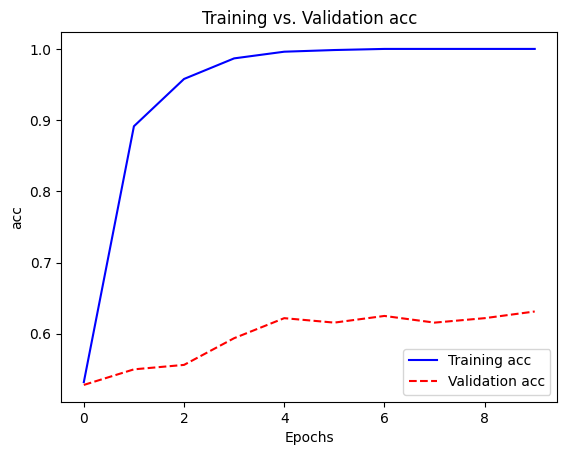

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'acc')

In [23]:
#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

13/13 [==============================] - 0s 2ms/step - loss: 0.6795 - acc: 0.6325
#Test accuracy:0.632


#### 문서의 순서정보를 활용하는 RNN 기반 문서 분류

RNN 모형을 적용함으로써 단어의 순서, 즉 문맥의 정보를 활용한 문서 분류를 수행한다.

In [24]:
max_words = 10000 #사용할 단어의 수
maxlen = 500

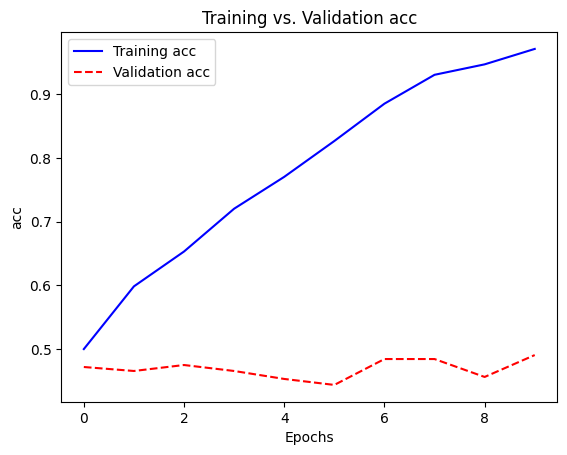

13/13 [==============================] - 0s 16ms/step - loss: 0.7375 - acc: 0.5325
Test accuracy : 0.533
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 323169 (1.23 MB)
Trainable params: 323169 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


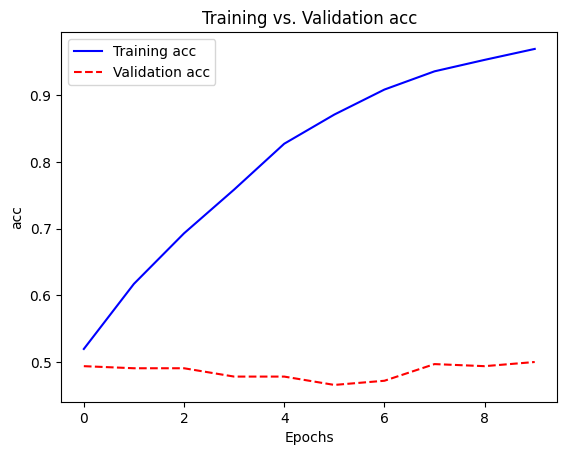

13/13 [==============================] - 1s 20ms/step - loss: 0.6922 - acc: 0.5525
Test accuracy : 0.553


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(max_words, 32),
    SimpleRNN(32), #이전과 달리 Flatten()대신 SimpleRNN() 모형을 사용한다. maxlen만큼의 시계열 데이터 사용,
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid') #출력층
])
model.summary()

adam = Adam(learning_rate = 1e-4)
model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ['acc'])
history = model.fit(X_train,y_train,
                    epochs = 10,
                    verbose = 0,
                    validation_split = 0.2)
plot_results(history, 'acc')

score = model.evaluate(X_test, y_test)
print(f"Test accuracy : {score[1]:.3f}")

#### 학습 결과

Train_set의 정확도는 갈수록 높아지는 반면에, Validation_set의 정확도는 0.5 근처에서 벗어나지 못하고 있다.
즉, overfitting이 일어났고 실제 학습은 거의 되고 있지 않다.
test_set도 정확도가 53.3%로 거의 분류가 안되는 것을 알 수 있다.

Q. 왜 이런 결과가 나왔을까?
**경사소실**
하나의 문서는 500개의 단어로 이루어져 있는데, 이는 500개의 층이 겹겹이 쌓여 있는 모형이다.
RNN의 목적은 앞에서부터 순서에 따라 다음 단어에 미치는 **영향을 축적하는 것**인데, 이것은 **경사소실 문제**로 인해 학습이 잘 되지 않는다.
이전 정보를 저장하지 못하고 소실되는 것 (만일, 영향이 0이면 이 0은 더이상 정보를 쌓을 수 없다.)
→ LSTM으로 보완 가능


### LSTM, Bi-LSTM과 GRU를 이용한 성능 개선

LSTM의 목적은 앞부분의 정보가 뒤로 갈수록 소실되는 것을 방지하기 위해 장기의존성과 단기 의존성을 모두 표현하고 학습하는 것이다.
즉, 기억 손실이 없는 컨베이어 벨트를 추가로 만들었다고 요약할 수 있다.

GRU(Gated Recurrent Unit)은 LSTM을 간소화한 모형으로, LSTM에 비해 계산량이 적고 속도가 빠르면서도 좋은 성능을 낸다.

RNN을 개선하는 또 다른 방법은 양방향으로 모형을 구축하는 것이다.
지금까지 가정한 것은 항상 앞 두 단어가 뒤 단어에 영향을 미친다는 것이다. 따라서 모형도 정보의 축적이 정방향으로만 이루어진다.
하지만, 뒤 단어가 앞 단어에 영향을 미칠수 있다. 이러한 영향을 고려한 것이 양방향(Bi-directional) LSTM이다.
→ 두 개 층의 LSTM을 구현하고 각 층의 은닉노드를 연결해 완전한 은닉 노드를 만든다.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 714369 (2.73 MB)
Trainable params: 714369 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


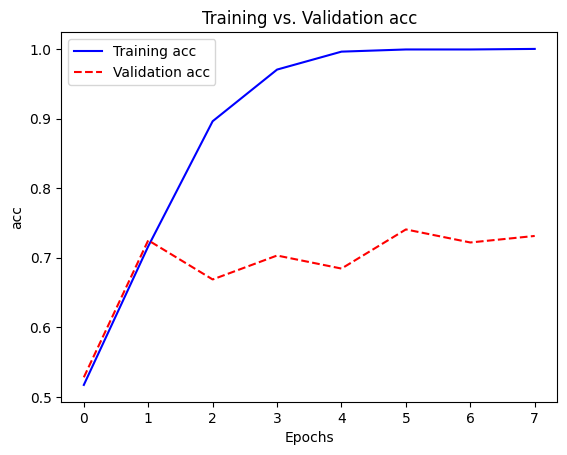

13/13 [==============================] - 3s 116ms/step - loss: 1.0632 - acc: 0.7575
#Test accuracy : 0.757


In [27]:
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)), #양방향 LSTM 설정
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])

history = model.fit(X_train, y_train, epochs = 8,
                    verbose = 0, validation_split = 0.2)

plot_results(history, 'acc')

score = model.evaluate(X_test, y_test)
print(f"#Test accuracy : {score[1]:.3f}") #정확도가 simpleRNN에 비해 월등히 좋아진 것을 볼 수 있다.

#### 딥러닝의 문제점
1 . 딥러닝은 데이터를 많이 요구한다.
워드 임베딩 단계에서 각 단어들은 말중치 안에서의 의미를 학습해 밀집 벡터로 변환되는데, 말뭉치가 충분하지 않으면 제대로 이루어지지 않는다.
→ 이를 개선하기 위해서 학습된 가중치를 word2vec와 같은 기존의 학습된 모형에서 가져온다.
(하지만, 일반적인 문서를 통해 학습된 가중치를 가져오기 때문에 분석에 해당되는 모델에는 적용이 잘 안될 수도 있다.)


In [28]:
###예측
y_pred = np.round(model.predict(X_test[:10]))
for pred, y_t in zip(y_pred, y_test[:10]):
    print(
        f'predicted value : {pred[0]}, true value : {y_t}, so the prediction is {pred[0] == y_t}'
    )


1/1 [==============================] - 1s 995ms/step
predicted value : 1.0, true value : 0, so the prediction is False
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 1.0, true value : 1, so the prediction is True
predicted value : 0.0, true value : 1, so the prediction is False
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
predicted value : 0.0, true value : 0, so the prediction is True
